<img src='./img/logo_header.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='100%'></img>

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./21_Sentinel-3_OLCI_RGB.ipynb"><< 21 - Sentinel-3 OLCI RGB </a><span style="float:right;"><a href="./31_Sentinel-5P_TROPOMI_CO.ipynb">31 - Sentinel-5P TROPOMI CO >></a></span>

# 2.2 Sentinel-3 SLSTR Near-Real-Time Fire Radiative Power (FRP)

###  Example Portugal fires in July 2020

The [Copernicus Near-Real-Time Sentinel 3 Fire Radiative Power](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product identifies the location, and quantifies the radiative power, of any hotspot present on land and ocean Earth surfaces, that radiates a heating signal within a pixel size of 1 km2.

All threatening hotspots are identified and characterised within three hours from SLSTR observation sensing time.
The current version of the NRT S3 FRP processor is mainly applicable during the night. The product identifies fire hotspots emitting radiations from MWIR (3.7 um) and SWIR (2.25 um). Hotspot identfied by the MWIR channel are typically less intensive fires with a temperature less than 1100 Kelvin, whereas hotspot identified by the SWIR channel are more intensive fires with a temperature above 1100 Kelvin.

Get more product specifications [here](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207).

<br>

#### Module outline:
* [1 - Load Sentinel-3 SLSTR FRP data](#load_s3_frp)
* [2 - Load, mask and regrid FRP computed from MWIR channel (3.7 um)](#load_mwir)
* [3 - Load, mask and regrid FRP computed from SWIR channel (2.25 um)](#load_swir)
* [4 - Load, mask and regrid FRP computed from SWIR channel (2.25 um) with SAA filter applied](#load_swir_nosaa)

<br>

<hr>

#### Load required libraries

In [2]:
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as pltfacebook
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [3]:
%run ./functions.ipynb

<hr>

## <a id='load_s3_frp'></a>Load Sentinel-3 SLSTR Near-Real-Time FRP data

Sentinel-3 SLSTR FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `open_dataset` function.


#### Load `SLSTR FRP` data with xarray's `open_dataset()` function

Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW] --> fires with temperatures < 1100 Kelvin
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW] --> fires with temperatures > 1100 Kelvin
- `FLAG_SWIR_SAA` - Flag values to filter out South Atlantic ANomalies (SAA) & other transient / spurious events, only applicable to FRP SWIR

In [4]:
frp_dir = './eodata/sentinel3/slstr/2020/07/25/'
frp_xr = xr.open_dataset(frp_dir+'FRP_3b_in.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 429, rows: 2000)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fires) float32 ...
    Glint_angle             (fires) float64 ...
    IFOV_area               (fires) float64 ...
    TCWV                    (fires) float64 ...
    n_window                (fires) int16 ...
    n_water                 (fires) int16 ...
    n_cloud                 (fires) int16 ...
    n_SWIR_fire             (fires) float32 ...
    flags                   (rows, columns) uint32 ...
Attributes:
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3B_SL_2_FRP____20200725T214818_20200725T215318_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 02.00
    history:                 
    references:             S3MPC ACR FRP 003 - i1r2 - SLSTR L2 Product Data ...
    contact:                ops@eumetsat.int
    creation_time:          2020-07-26T00:21:38Z
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  11723
    start_time:             2020-07-25T21:48:17.819223Z
    stop_time:              2020-07-25T21:53:17.808307Z
    track_offset:           998
    start_offset:           3109

<br>

#### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which will be required for the regridding process.

In [5]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lon_frp

<xarray.DataArray 'longitude' (fires: 429)>
array([-5.21162 , -4.958087, -4.352265, ..., -2.915329, -2.925332, -2.947486])
Dimensions without coordinates: fires
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0

<br>

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [6]:
sampling_lat_FRP_grid = 0.15        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.15        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots


lat_min               = 35.        # Minimum latitude for mapping plot [deg N]
lat_max               = 45.        # Maximum latitude for mapping plot [deg N]
lon_min               = -10.        # Minimum lonitude for mapping plot [deg E]
lon_max               = 10.        # Maximum lonitude for mapping plot [deg E]

<br>

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

<br>

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that the variables contains 2199 fire entries.

In [7]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 429)>
array([14.649502, 11.180686, 12.538479, ...,  2.165554,  1.377944,  3.029317])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

The next step is to extract (mask) only FRP pixels that are valid. Valid pixels are different to -1. You can use the function `generate_masked_array` to extract the valid pixels.

In [8]:
masked_frp_mwir = generate_masked_array(frp_mwir, frp_mwir, -1.,operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 389)>
array([1.46495019e+01, 1.11806856e+01, 1.25384788e+01, 1.22277098e+01,
       1.21867129e+01, 1.45304002e+01, 1.45336300e+01, 5.13395992e+00,
       1.82057425e+01, 1.24073083e+01, 1.19115763e+01, 1.62011408e+01,
       1.22905227e+01, 1.40449398e+01, 1.14416781e+01, 8.29657703e+00,
       1.43244168e+01, 1.25964245e+01, 1.25964245e+01, 1.18847369e+01,
       9.80782649e+00, 1.21900976e+01, 1.34344298e+01, 1.45343539e+01,
       2.57714382e+01, 2.51056931e+01, 1.25011844e+01, 1.26549377e+01,
       3.17003736e+01, 9.76884901e+00, 2.46930755e+01, 3.10587591e+01,
       2.55043100e+01, 1.32673972e+01, 1.01260628e+01, 3.70907928e+01,
       1.03955716e+01, 2.15844698e+01, 2.79927474e+01, 9.50849129e+00,
       1.08637002e+01, 1.49323798e+01, 1.73938150e+01, 1.10870434e+01,
       1.01434319e+01, 1.04358093e+01, 1.71884659e+01, 1.85588728e+01,
       1.87688468e+01, 1.90556540e+01, 1.99878069e+01, 2.43185582e+01,
       6.59404797e+00, 6.22173193e+00, 7.17832738e+00, 6.31282840e+00,
       1.39043150e+01, 6.34767899e+00, 1.02200595e+01, 1.25452133e+01,
       1.78018731e+01, 2.80508479e+01, 4.08449415e+00, 4.40912301e+00,
       4.48273126e+00, 4.21414978e+00, 1.73196423e+00, 9.98046633e+01,
       3.12506873e+01, 1.04475663e+01, 8.07374904e+00, 6.93146059e+01,
       6.93535173e+01, 9.82688568e+00, 1.93591255e+00, 2.29418845e+00,
       6.67762793e+02, 5.35921477e+02, 1.44457277e+02, 6.46997395e+01,
...
       6.07713391e+00, 3.94234913e+00, 3.58179259e+00, 7.55678790e+00,
       7.30785891e+00, 4.90235882e+00, 8.12728226e+00, 6.66974373e+00,
       6.94792514e+00, 8.37497637e+00, 7.57172964e+00, 3.16480909e+00,
       4.96607402e+00, 6.94827282e+00, 4.48370596e+00, 4.01466494e+00,
       3.48447774e+00, 3.88434254e+00, 3.01770714e+00, 2.89751348e+00,
       4.92016351e+00, 6.59998204e+00, 6.71967994e+00, 6.25359140e+00,
       1.07218448e+01, 5.43588726e+00, 5.69266137e+00, 1.78620190e+00,
       1.95399677e+00, 2.39298761e+00, 4.35282594e+00, 1.66746549e+00,
       1.19259719e+00, 1.73664333e+00, 5.77818664e+00, 5.91517078e+00,
       7.93891396e+00, 4.15237991e+00, 1.98832823e+00, 3.61222697e+00,
       4.61971153e+00, 4.03111317e+00, 2.94496886e+00, 2.36106570e+00,
       5.42352335e+00, 1.82621676e+00, 8.27835231e+00, 7.99779965e+00,
       4.87195031e+00, 1.92157341e+00, 8.55960278e+00, 7.85912248e+00,
       3.82270714e+00, 6.93744740e+00, 4.62387794e+00, 4.28525564e+00,
       2.85237852e+00, 2.52759728e+00, 1.80228654e+00, 1.40833483e+00,
       2.22172109e+00, 2.41393839e+00, 2.78807542e+00, 9.11904042e+00,
       9.10471782e+00, 5.66432630e+00, 4.01601597e+00, 4.49971741e+00,
       4.01565616e+00, 2.72933341e+00, 2.87028746e+00, 7.27071377e+00,
       6.63191530e+00, 2.57912756e+00, 2.16555355e+00, 1.37794360e+00,
       3.02931713e+00])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

Let us retrieve the number of of hotspots / fires in total and per category.

In [9]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(429, 389)

<br>

### Generate a gridded FRP array

Let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can define the function `slstr_frp_gridding` and you can then reuse it to apply it for other data variables.

In [10]:
def slstr_frp_gridding(parameter_array, parameter, lat_min, lat_max, lon_min, lon_max, 
                       sampling_lat_FRP_grid, sampling_lon_FRP_grid, n_fire, lat_frp, lon_frp, **kwargs):
    """ 
    Produces gridded data of Sentinel-3 SLSTR NRT Fire Radiative Power Data
    
    Parameters:
        parameter_array(xarray.DataArray): xarray.DataArray with extracted data variable of fire occurences
        parameter(str): NRT S3 FRP channel - either `mwir`, `swir` or `swir_nosaa`
        lat_min, lat_max, lon_min, lon_max(float): Floats of geographical bounding box
        sampling_lat_FRP_grid, sampling_long_FRP_grid(float): Float of grid cell size
        n_fire(int): Number of fire occurences
        lat_frp(xarray.DataArray): Latitude values of occurred fire events
        lon_frp(xarray.DataArray): Longitude values of occurred fire events
        **kwargs: additional keyword arguments to be added. Required for parameter `swir_nosaa`, where the function
                  requires the xarray.DataArray with the SAA FLAG information.  

    Returns:
        the gridded xarray.Data Array and latitude and longitude grid information
    """ 
    n_lat = int( (np.float32(lat_max) - np.float32(lat_min)) / sampling_lat_FRP_grid ) + 1 # Number of rows per latitude sampling
    n_lon = int( (np.float32(lon_max) - np.float32(lon_min)) / sampling_lon_FRP_grid ) + 1 # Number of lines per longitude sampling

    
    slstr_frp_gridded = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.

    lat_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    lon_grid = np.zeros( [n_lat, n_lon], dtype='float32' ) - 9999.
    
    if (n_fire >= 0):
    
    # Loop on i_lat: begins
        for i_lat in range(n_lat):
                    
        # Loop on i_lon: begins
            for i_lon in range(n_lon):
                        
                lat_grid[i_lat, i_lon] = lat_min + np.float32(i_lat) * sampling_lat_FRP_grid + sampling_lat_FRP_grid / 2.
                lon_grid[i_lat, i_lon] = lon_min + np.float32(i_lon) * sampling_lon_FRP_grid + sampling_lon_FRP_grid / 2.
                            
            # Gridded SLSTR FRP MWIR Night - All days
                if(parameter=='swir_nosaa'):
                    FLAG_FRP_SWIR_SAA_nc = kwargs.get('flag', None)
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.) & (FLAG_FRP_SWIR_SAA_nc[:] == 0), False, True)
                else:
                    mask_grid = np.where( 
                        (lat_frp[:] >= lat_min + np.float32(i_lat) * sampling_lat_FRP_grid)  & 
                        (lat_frp[:] < lat_min + np.float32(i_lat+1) * sampling_lat_FRP_grid) & 
                        (lon_frp[:] >= lon_min + np.float32(i_lon) * sampling_lon_FRP_grid)  & 
                        (lon_frp[:] < lon_min + np.float32(i_lon+1) * sampling_lon_FRP_grid) &
                        (parameter_array[:] != -1.),  False, True)
                            
                masked_slstr_frp_grid = np.ma.array(parameter_array[:], mask=mask_grid)
                            
                if len(masked_slstr_frp_grid.compressed()) != 0:
                    slstr_frp_gridded[i_lat, i_lon]  = np.sum(masked_slstr_frp_grid.compressed())
    return slstr_frp_gridded, lat_grid, lon_grid
    

<br>

Apply the function `slstr_frp_gridding` to the `frp_mwir` data array.

In [12]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array = frp_mwir, 
                                                       parameter = 'mwir', 
                                                       lat_min = lat_min, 
                                                       lat_max = lat_max, 
                                                       lon_min = lon_min, 
                                                       lon_max = lon_max, 
                                                       sampling_lat_FRP_grid = sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid = sampling_lon_FRP_grid, 
                                                       n_fire = n_fire_MWIR,
                                                      lat_frp=lat_frp,
                                                      lon_frp=lon_frp)
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[35.075, 35.075, 35.075, ..., 35.075, 35.075, 35.075],
        [35.225, 35.225, 35.225, ..., 35.225, 35.225, 35.225],
        [35.375, 35.375, 35.375, ..., 35.375, 35.375, 35.375],
        ...,
        [44.675, 44.675, 44.675, ..., 44.675, 44.675, 44.675],
        [44.825, 44.825, 44.825, ..., 44.825, 44.825, 44.825],
        [44.975, 44.975, 44.975, ..., 44.975, 44.975, 44.975]],
       dtype=float32),
 array([[-9.925, -9.775, -9.625, ...,  9.725,  9.875, 10.025],
        [-9.925, -9.775, -9.625, ...,  9.725,  9.875, 10.025],
        [-9.925, -9.775, -9.625, ...,  9.725

<br>

Mask out the invalid pixels for plotting. You can used numpy's function `np.ma.masked_array()` for this.

In [13]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir          = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

<br>

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [14]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



<br>

### Visualize the masked data array with matplotlib's `pcolormesh()` function

You can define a function for the plotting code, so it can be easily re-used to plot other FRP data variables. Let us call the function `visualize_s3_frp`.

In [15]:
def visualize_s3_frp(data, lat, lon, unit, longname, textstr_1, textstr_2, vmax):
    """ 
    Visualizes a numpy.Array (Sentinel-3 SLSTR NRT FRP data) with matplotlib's pcolormesh function and adds two
    text boxes to the plot.
    
    Parameters:
        data(numpy.MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        lat(numpy.Array): array with longitude values
        lon(numpy.Array) : array with latitude values
        unit(str): unit of the resulting plot
        longname(str): Longname to be used as title
        textstr_1(str): String to fill box 1
        textstr_2(str): String to fill box 2
        vmax(float): Maximum value of color scale
    """
    fig=plt.figure(figsize=(20, 15))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(lon, lat, data, 
                        cmap=cm.autumn_r, transform=ccrs.PlateCarree(),
                        vmin=0,
                        vmax=vmax)

    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.bottom_labels=False
    gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.029, pad=0.025)
    cbar.set_label(unit, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(longname, fontsize=20, pad=40.0) 

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box on the right side of the plot
    ax.text(1.1, 0.9, textstr_1, transform=ax.transAxes, fontsize=16,
        verticalalignment='top', bbox=props)

    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(1.1, 0.85, textstr_2, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)
    plt.show()

<br>

Now, you can apply the function `visualize_s3_frp` and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

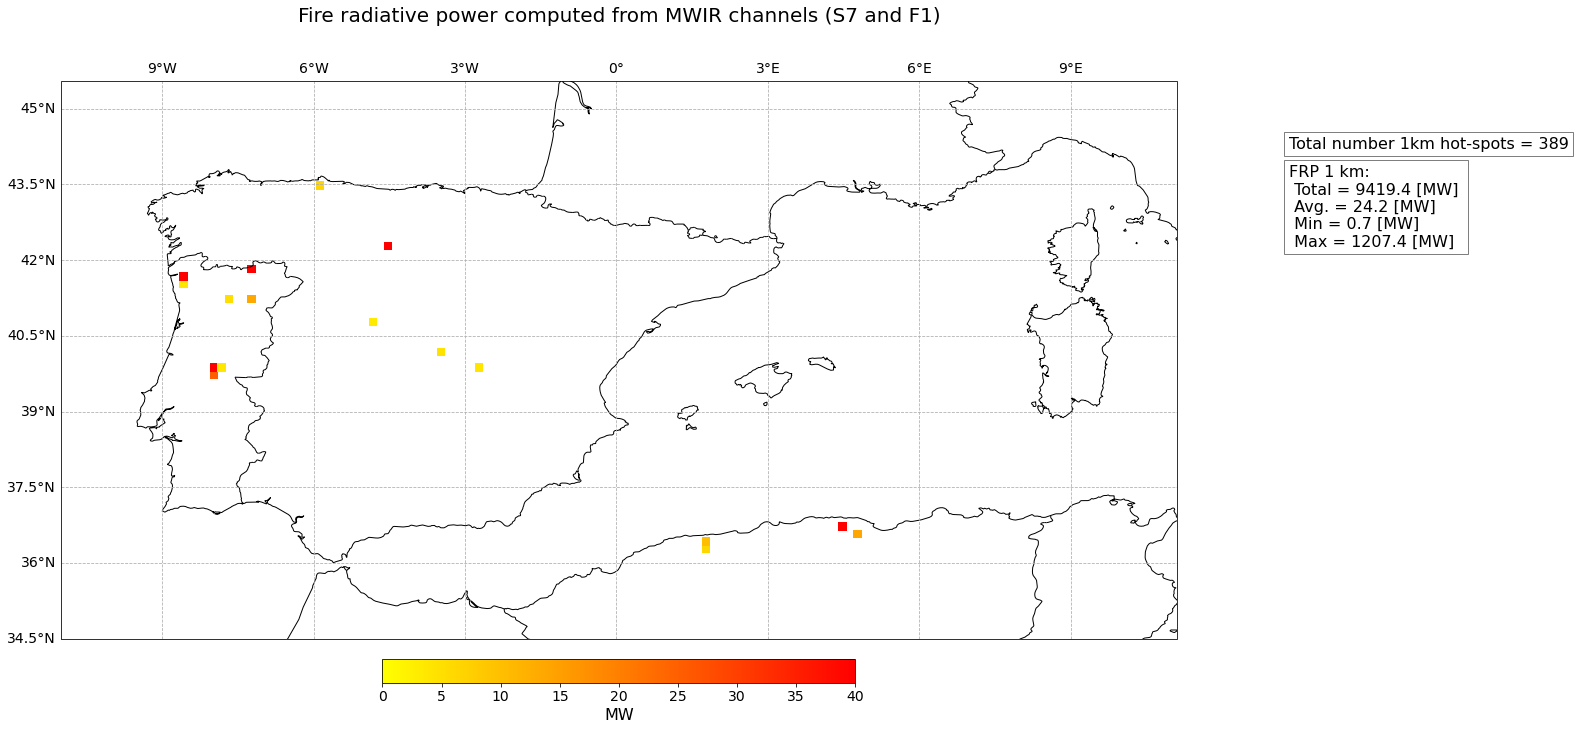

In [16]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data = D_mwir[:,:],
                 lat = lat_grid, 
                 lon = lon_grid, 
                 unit = unit, 
                 longname = long_name, 
                 textstr_1 = textstr_1, 
                 textstr_2 = textstr_2, 
                 vmax = FRP_plot_max_grid)

<br>

Let us now repeat the processing steps above and let us process and visualize the `FRP computed from the SWIR channel`.

## <a id='load_swir'></a>Load, mask and regrid `FRP computed from SWIR channel (2.25 um)`

Load the `FRP_SWIR` data variable from the loaded `netCDF` file.

In [17]:
frp_swir = frp_xr['FRP_SWIR']
frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 429)>
array([-1., -1., -1., ..., -1., -1., -1.])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

Filter only valid pixels and filter all pixels with -1 out.

In [18]:
masked_frp_swir = generate_masked_array(xarray = frp_swir, 
                                        mask = frp_swir, 
                                        threshold = -1., 
                                        operator='!=', 
                                        drop=True)
masked_frp_swir

<xarray.DataArray 'FRP_SWIR' (fires: 97)>
array([  1.60421166,  11.88419029,  35.60370208,  18.46427907,
         6.89185747,  29.0259247 , 113.75635688,  35.09730205,
         6.99548882,  45.98821706,  53.83491053,  65.25643469,
        47.97575911,  10.49607165,  10.82767184,  53.06553871,
        62.05661095,  10.91072687,   8.19322108,   8.08566051,
         4.64051177,   4.72111574,  65.07442418,   9.75872405,
         9.34529214, 301.8485463 ,  73.52021014, 100.95695813,
        90.66006118, 203.45169554, 250.82572669,   4.62911219,
         4.15876051,  54.27041247,  13.69087918,  66.87838478,
       321.45317031,  11.44557539,   7.70257534, 264.95606528,
         9.99468608, 101.20843703,   9.73136576,  56.86543845,
       162.38660367,  16.31231245,  20.56377192,  46.15602413,
         8.86904681,  12.46340193,  32.2955095 ,  56.93711432,
         7.68034693,   3.80339681,  52.77451056,  16.30648072,
         7.81049956,   1.79730287,   2.22522056,   7.77352113,
         3.77230181,  14.43400748,  16.7993282 ,   8.2025962 ,
        19.82994801,   3.61116637,   1.09619791,  21.11811357,
        13.22887459,  52.37007286,  23.55461566,  23.20218315,
        10.16406566,   9.03770237,  16.30605363,   7.80074602,
        14.38152811,   6.91693755,   7.71681852,   8.79010764,
         9.08261123,   4.81942443,   4.79415006,   3.66948721,
         6.01615562,   3.3428238 ,   3.01905048,   3.85445059,
         4.79486139,   4.51074381,  29.77598844,   2.32296916,
        41.27789454,  20.14807684, 212.06558221,  13.93229863,
        29.10412224])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from SWIR channel (S6)
    units:      MW

<br>

Compute the number of total fires and per category.

In [19]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR          = len(masked_frp_swir.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR

(429, 97)

Apply the gridding function `slstr_frp_gridding` and grid the `FRP computed from the SWIR channel`.

In [21]:
FRP_SWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array = frp_swir, 
                                                       parameter = 'swir', 
                                                       lat_min = lat_min, 
                                                       lat_max = lat_max, 
                                                       lon_min = lon_min, 
                                                       lon_max = lon_max, 
                                                       sampling_lat_FRP_grid = sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid = sampling_lon_FRP_grid,
                                                       n_fire = n_fire_SWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)

FRP_SWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[35.075, 35.075, 35.075, ..., 35.075, 35.075, 35.075],
        [35.225, 35.225, 35.225, ..., 35.225, 35.225, 35.225],
        [35.375, 35.375, 35.375, ..., 35.375, 35.375, 35.375],
        ...,
        [44.675, 44.675, 44.675, ..., 44.675, 44.675, 44.675],
        [44.825, 44.825, 44.825, ..., 44.825, 44.825, 44.825],
        [44.975, 44.975, 44.975, ..., 44.975, 44.975, 44.975]],
       dtype=float32),
 array([[-9.925, -9.775, -9.625, ...,  9.725,  9.875, 10.025],
        [-9.925, -9.775, -9.625, ...,  9.725,  9.875, 10.025],
        [-9.925, -9.775, -9.625, ...,  9.725

<br>

Mask out all invalid pixels for plotting.

In [22]:
mask_valid = np.where(FRP_SWIR_grid[:,:] != -9999., False, True)
D_swir = np.ma.masked_array(FRP_SWIR_grid[:,:], mask=mask_valid)

<br>

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [23]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR)


FRP_sum      = np.sum(masked_frp_swir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



<br>

Apply the plotting function `visualize_s3_frp` and take some attributes from the data variable's attributes.

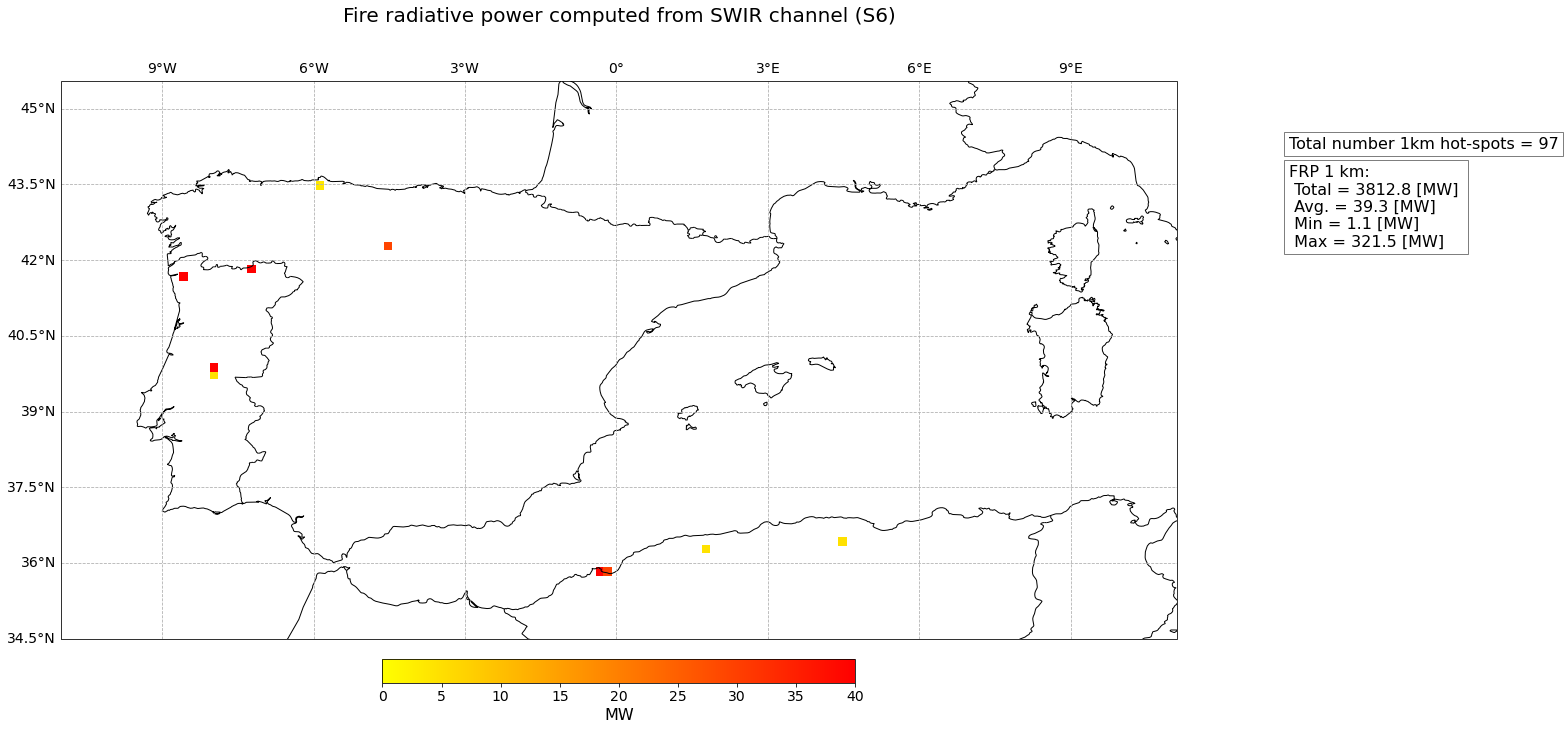

In [24]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data = D_swir[:,:],
                 lat = lat_grid, 
                 lon = lon_grid, 
                 unit = unit, 
                 longname = long_name, 
                 textstr_1 = textstr_1, 
                 textstr_2 = textstr_2, 
                 vmax = FRP_plot_max_grid)

<br>

Let us repeat the same processing steps for the `FRP computed from SWIR channel`, but with the SAA filter applied.

<br>

## <a id='load_swir_nosaa'></a> Load, mask and regrid `FRP computed from SWIR channel (2.25 um) with SAA filter applied`

Load the flag for the `South Atlantic Anomaly (SAA)` with the data variable name `FLAG_SWIR_SAA`. 

In [25]:
FLAG_FRP_SWIR_SAA_nc = frp_xr['FLAG_SWIR_SAA']
FLAG_FRP_SWIR_SAA_nc

<xarray.DataArray 'FLAG_SWIR_SAA' (fires: 429)>
array([-1, -1, -1, ..., -1, -1, -1], dtype=int16)
Dimensions without coordinates: fires
Attributes:
    long_name:      Flag South Atlantic Anomaly (SAA) suspected from SWIR cha...
    flag_values:    [-1  0  1  2  3  4]
    flag_meanings:  NA Unlikely Possible Spare Spare Spare

<br>

Apply the mask for only valid pixels of the `FRP SWIR` data variable and include the `FLAG_SWIR_SAA` as additional informaion.

In [26]:
mask_frp_swir_nosaa = xr.where((frp_swir!=-1.) & (FLAG_FRP_SWIR_SAA_nc==0), 1, 0)
mask_frp_swir_nosaa

masked_frp_swir_nosaa = xr.where(mask_frp_swir_nosaa==1, frp_swir, np.nan)
masked_frp_swir_nosaa

<xarray.DataArray (fires: 429)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,   1.60421166,
        11.88419029,          nan,          nan,  35.60370208,
        18.46427907,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,   6.89185747,          nan,
                nan,          nan,  29.0259247 , 113.75635688,
                nan,          nan,  35.09730205,          nan,
         6.99548882,  45.98821706,  53.83491053,          nan,
                nan,  65.25643469,          nan,          nan,
        47.97575911,          nan,          nan,          nan,
        10.49607165,          nan,          nan,          nan,
        10.82767184,          nan,  53.06553871,          nan,
                nan,  62.05661095,          nan,          nan,
        10.91072687,   8.19322108,   8.08566051,          nan,
         4.64051177,          nan,          nan,          nan,
                nan,          nan,          nan,   4.72111574,
                nan,          nan,  65.07442418,   9.75872405,
                nan,   9.34529214, 301.8485463 ,  73.52021014,
       100.95695813,          nan,          nan,  90.66006118,
...
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan])
Dimensions without coordinates: fires

<br>

Let us compute the total number fires and also of the category of `FRP SWIR` with filter applied.

In [27]:
n_fire_tot           = len(lat_frp[:])
n_fire_SWIR_NoSAA    = len(masked_frp_swir_nosaa.to_masked_array().compressed())

n_fire_tot, n_fire_SWIR_NoSAA

(429, 96)

<br>

Apply the gridding function `slstr_frp_gridding` to grid the filtered `FRP SWIR` data.

In [28]:
FRP_SWIR_NoSAA_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array = frp_swir, 
                                                             parameter = 'swir_nosaa', 
                                                             lat_min = lat_min, 
                                                             lat_max = lat_max, 
                                                             lon_min = lon_min, 
                                                             lon_max = lon_max, 
                                                             sampling_lat_FRP_grid = sampling_lat_FRP_grid,
                                                             sampling_lon_FRP_grid = sampling_lon_FRP_grid, 
                                                             n_fire = n_fire_SWIR_NoSAA,
                                                             lat_frp=lat_frp,
                                                             lon_frp=lon_frp,
                                                             flag=FLAG_FRP_SWIR_SAA_nc)


FRP_SWIR_NoSAA_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[35.075, 35.075, 35.075, ..., 35.075, 35.075, 35.075],
        [35.225, 35.225, 35.225, ..., 35.225, 35.225, 35.225],
        [35.375, 35.375, 35.375, ..., 35.375, 35.375, 35.375],
        ...,
        [44.675, 44.675, 44.675, ..., 44.675, 44.675, 44.675],
        [44.825, 44.825, 44.825, ..., 44.825, 44.825, 44.825],
        [44.975, 44.975, 44.975, ..., 44.975, 44.975, 44.975]],
       dtype=float32),
 array([[-9.925, -9.775, -9.625, ...,  9.725,  9.875, 10.025],
        [-9.925, -9.775, -9.625, ...,  9.725,  9.875, 10.025],
        [-9.925, -9.775, -9.625, ...,  9.725

<br>

Mask out the invalid pixels for plotting.

In [29]:
mask_valid = np.where(FRP_SWIR_NoSAA_grid[:,:] != -9999., False, True)
D_swir_NoSAA = np.ma.masked_array(FRP_SWIR_NoSAA_grid[:,:], mask=mask_valid)

<br>

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [30]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_SWIR_NoSAA)


FRP_sum      = np.sum(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_swir_nosaa.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_swir_nosaa.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'


<br>

Apply the function `visualize_s3_frp` to visualize the data and make use of the data variable's attributes.

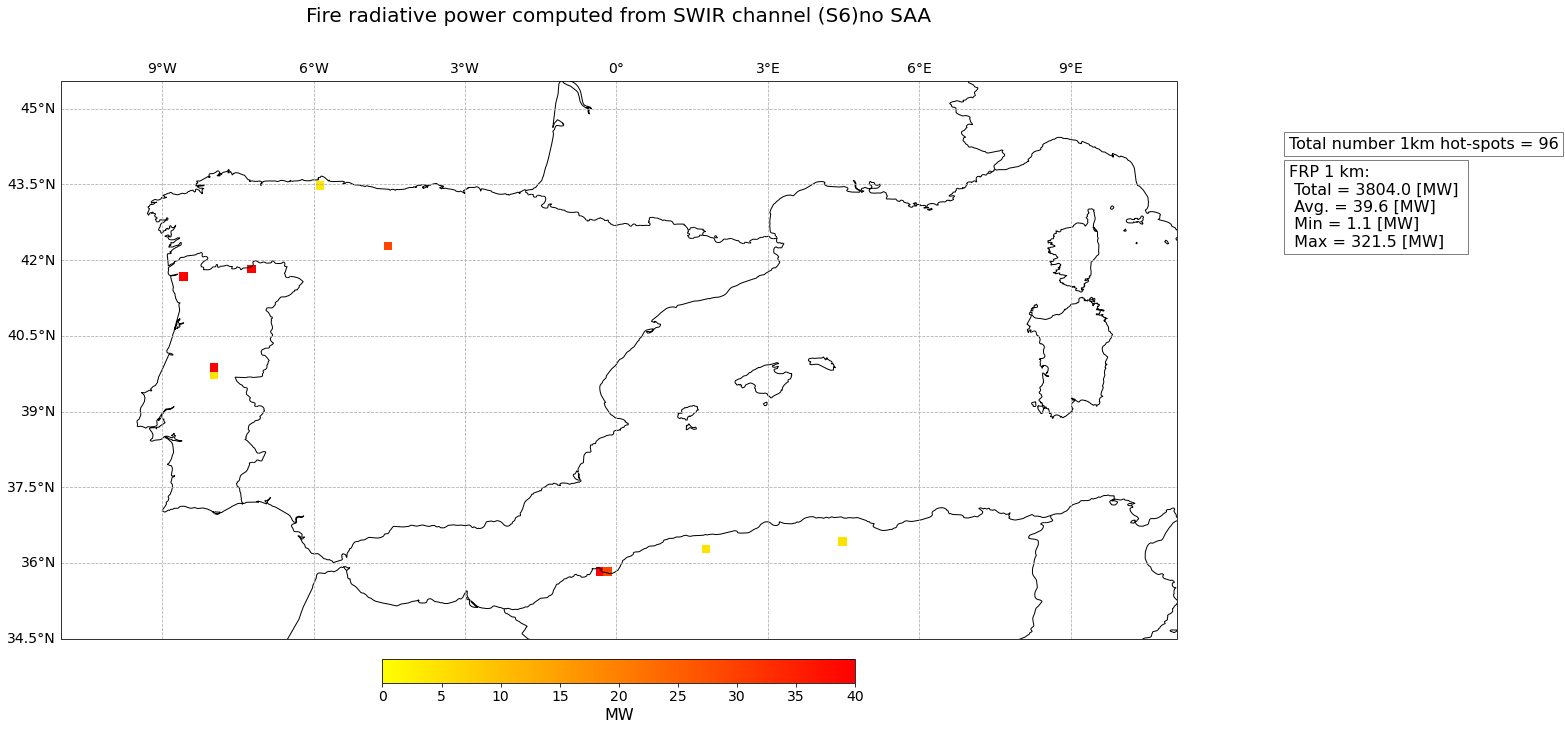

In [31]:
long_name = frp_swir.long_name
unit = frp_swir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data = D_swir_NoSAA[:,:],
                 lat = lat_grid, 
                 lon = lon_grid, 
                 unit = unit, 
                 longname = long_name + 'no SAA', 
                 textstr_1 = textstr_1, 
                 textstr_2 = textstr_2, 
                 vmax = FRP_plot_max_grid)

<br>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./21_Sentinel-3_OLCI_RGB.ipynb"><< 21 - Sentinel-3 OLCI RGB </a><span style="float:right;"><a href="./31_Sentinel-5P_TROPOMI_CO.ipynb">31 - Sentinel-5P TROPOMI CO >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.